# Implementing convolutions

This notebook will walk you through the process of implementing a reasonably efficient convolutional.  We'll do this using native numpy for the purposes of illustration, but in the homework, you'll need to implement these all using your own straight-C (and GPU) implementations.

## Convolutions

Here we will build up some of the basic approaches for convolution, from a simple all-for-loop algorithm to an algorithm that uses a single matrix multiplication plus resize operations.

### Storage order

In the simple fully-connected networks we have been developing so far, hidden units are typically simply represented as vectors, i..e., a quantity $z \in \mathbb{R}^n$, or when representing an entire minibatch, a matrix $Z \in \mathbb{R}^{B \times n}$.  But when we move to convolutional networks, we need to include additional structure in the hidden unit.  This is typically done by representing each hidden vector as a 3D array, with dimensions `height x width x channels`, or in the minibatch case, with an additional batch dimension.  That is, we could represent a hidden unit as an array

```c++
float Z[BATCHES][HEIGHT][WIDTH][CHANNELS];
```

The format above is referred to as NHWC format (number(batch)-height-width-channel).  However, there are other ways we can represent the hidden unit as well.  For example, PyTorch defaults to the NCHW format (indexing over channels in the second dimension, then height and width), though it can also support NHWC in later versions.  There are subtle but substantial differences in the performance for each different setting: convolutions are typically faster in NHWC format, owing to their ability to better exploit tensor cores; but NCHW format is typically faster for BatchNorm operation (because batch norm for convolutional networks operates over all pixels in an individual channel).

Although less commonly discussed, there is a simliar trade-off to be had when it comes to storing the convolutional weights (filter) as well.  Convolutional filters are specified by their kernel size (which can technically be different over different height and width dimensions, but this is quite uncommon), their input channels, and their output channels.  We'll store these weights in the form:

```c++
float weights[KERNEL_SIZE][KERNEL_SIZE][IN_CHANNELS][OUT_CHANNELS];
```

Again, PyTorch does things a bit differently here (for no good reason, as far as I can tell, it was just done that way historically), storing weight in the order `OUT_CHANNELS x IN_CHANNELS x KERNELS_SIZE x KERNEL_SIZE`.

## Convolutions with simple loops

Let's begin by implementing a simple convolutional operator.  We're going to implement a simple version, which allows for different kernel sizes but which _doesn't_ have any built-in padding: to implement padding, you'd just explicitly form a new ndarray with the padding built in.  This means that if we have an $H \times W$ input image and convolution with kernel size $K$, we'll end up with a $(H - K + 1) \times (W - K + 1)$ image.

Although it's "cheating" in some sense, we're going to use PyTorch as a reference implementation of convolution that we will check against.  However, since PyTorch, as mentioned above, uses the NCHW format (and stores the convolutional weights in a different ordering as well), and we'll use the NHWC format and the weights ordering stated above, we will need to swap things around for our reference implementation.

In [41]:
import torch
import torch.nn as nn
import numpy as np
def conv_reference(Z, weight):
    # NHWC -> NCHW
    Z_torch = torch.tensor(Z).permute(0,3,1,2)
    
    # KKIO -> OIKK
    W_torch = torch.tensor(weight).permute(3,2,0,1)
    
    # run convolution
    out = nn.functional.conv2d(Z_torch, W_torch)
    
    # NCHW -> NHWC
    return out.permute(0,2,3,1).contiguous().numpy()

In [42]:
Z = np.random.randn(10,32,32,8)
W = np.random.randn(3,3,8,16)
out = conv_reference(Z,W)
print(out.shape)

(10, 30, 30, 16)


In [43]:
%%time
out = conv_reference(Z,W)

CPU times: user 1.44 ms, sys: 2.57 ms, total: 4.01 ms
Wall time: 1.48 ms


Now let's consider the simplest possible implementation of a convolution, that just does the entire operation using for loops.

In [44]:
def conv_naive(Z, weight):
    N,H,W,C_in = Z.shape
    K,_,_,C_out = weight.shape
    
    out = np.zeros((N,H-K+1,W-K+1,C_out));
    for n in range(N):
        for c_in in range(C_in):
            for c_out in range(C_out):
                for y in range(H-K+1):
                    for x in range(W-K+1):
                        for i in range(K):
                            for j in range(K):
                                out[n,y,x,c_out] += Z[n,y+i,x+j,c_in] * weight[i,j,c_in,c_out]
    return out

We can check to make sure this implementation works by comparing to the PyTorch reference implementation.

In [45]:
out2 = conv_naive(Z,W)
print(np.linalg.norm(out - out2))

1.2158976566098508e-12


The implementation works, but (not surprisingly, since you would never want to actually have a 7-fold loop in interpreted code), the PyTorch version is _much much_ faster; YMMV, but on my laptop, the naive implementation is more than 2000 times slower.

In [46]:
%%time
out2 = conv_naive(Z,W)

CPU times: user 3.99 s, sys: 10.1 ms, total: 4 s
Wall time: 4 s


In [47]:
%%time
out = conv_reference(Z,W)

CPU times: user 1.95 ms, sys: 2.62 ms, total: 4.57 ms
Wall time: 1.73 ms


## Convolutions as matrix mulitplications

Ok, but, no one is going to actually implement convolutions elementwise in Python.  Let's see how we can start to do much better.  The simplest way to make this much faster (and frankly, a very reasonable implementation of convolution) is to perform it as a sequence of matrix multiplications.  Remember that a kernel size $K = 1$ convolution is equivalent to performing matrix multiplication over the channel dimensions.  That is, suppose we have the following convolution.

In [48]:
W1 = np.random.randn(1,1,8,16)
out = conv_reference(Z,W1)
print(out.shape)

(10, 32, 32, 16)


Then we could implement the convolution using a _single_ matrix multiplication.

In [49]:
out2 = Z @ W1[0,0]
print(np.linalg.norm(out - out2))

0.0


In [50]:
W1[0,0].shape

(8, 16)

We're here exploiting the nicety that in numpy, when you compute a matrix multiplication by a multi-dimensional array, it will treat the leading dimensions all as rows of a matrix.  That is, the above operation would be equivalent to:

In [51]:
out2 = (Z.reshape(-1,8) @ W1[0,0]).reshape(Z.shape[0], Z.shape[1], Z.shape[2], W1.shape[3])

This strategy immediately motivates a very natural approach to convolution: we can iterate over just the kernel dimensions $i$ and $j$, and use matrix multiplication to perform the convolution.

In [52]:
def conv_matrix_mult(Z, weight):
    N,H,W,C_in = Z.shape
    K,_,_,C_out = weight.shape
    out = np.zeros((N,H-K+1,W-K+1,C_out))
    
    for i in range(K):
        for j in range(K):
            out += Z[:,i:i+H-K+1,j:j+W-K+1,:] @ weight[i,j]
            # 这句话的意思就是
            #   1. C_out个卷积核的第[i,j]位置处的元素都取出来：是一个C_in * C_out的矩阵
            #      类比1*1卷积，那么就是 C H W * C_in @ C_in * C_out = C H W * C_out
            #   2. 现在不是1*1卷积了，而是K*K，每个卷积核的元素不能访问到所有的为止
            #      比如说：第[0,0]处的值只能卷到[0:H-K+1, 0:W-K+1]处的值
            #   3. 所以遍历形式下就是[i:i+H-K+1,j:j+W-K+1]
            #   4. += 是因为，不同的卷积核的值，可以卷到同一个地方，所以要累加（这是显然的）
            
            # 或者从另一个角度来看：
            #   1. 当我们取出weight[i, j]之后，就相当于是一个1*1卷积了
            #      那么这个1*1卷积能卷的图像其实是原图像 [H,W,C_in] 的一个子集
            #      这个子集是：[N,i:i+H-K+1, j:j+H-K+1, C_in]
            #   2. 然后将K*K个1*1卷积的重合的部分相加（+=的含义）
    return out
    

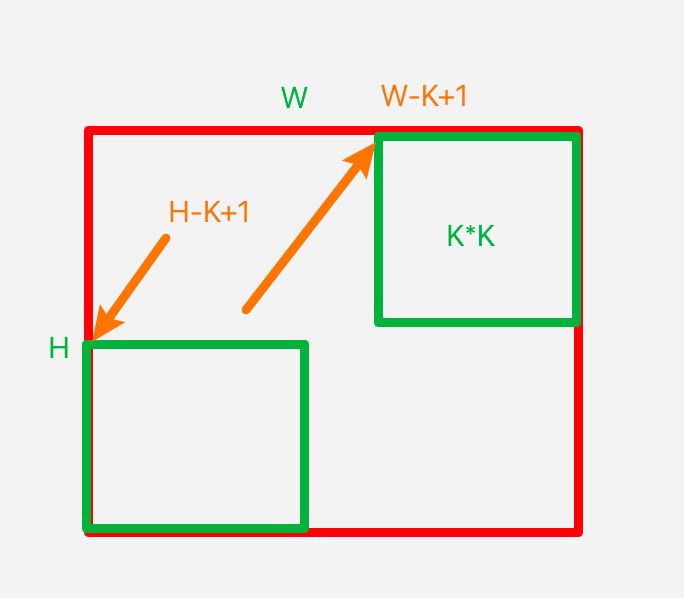

In [53]:
Z = np.random.randn(100,32,32,8)
W = np.random.randn(3,3,8,16)

out = conv_reference(Z,W)
out2 = conv_matrix_mult(Z,W)
print(np.linalg.norm(out - out2))

3.0827026693195323e-12


This works as well, as (as expected) is _much_ faster, starting to be competetive even with the PyTorch version (about 2-3x slower on my machine).  Let's in fact increase the batch size a bit to make this a more lengthy operation.

In [54]:
%%time
out = conv_reference(Z,W)

CPU times: user 44.1 ms, sys: 9.46 ms, total: 53.5 ms
Wall time: 10.9 ms


In [55]:
%%time
out = conv_matrix_mult(Z,W)

CPU times: user 139 ms, sys: 11.3 ms, total: 151 ms
Wall time: 27 ms


## Manipulating matrices via strides

Before implementing convolutions via im2col, let's consider an example that actually has nothing to do with convolution.  Instead, let's consider the efficient matrix multiplication operations that we discussed in an earlier lecture.  Normally we think of storing a matrix as a 2D array:

在实现im2col之前，让我们考虑一个与卷积无关的示例。相反，让我们考虑一下我们在之前的讲座中讨论过的高效矩阵乘法操作。通常我们将矩阵存储为二维数组：

```c++
float A[M][N];
```

In the typical row-major format, this will store each N dimensional row of the matrix one after the other in memory.  However, recall that in order to make better use of the caches and vector operations in modern CPUs, it was beneficial to lay our our matrix memory groups by individual small "tiles", so that the CPU vector operations could efficiently access operators

在典型的行主序（row-major）格式中，这将按顺序将矩阵的每个N维行存储在内存中。然而，回想一下为了更好地利用现代CPU的缓存和矢量操作，通过将矩阵内存分组为个别的小“瓦片（tile）”，以便CPU矢量操作可以高效地访问运算符，这是有益的。

    float A[M/TILE][N/TILE][TILE][TILE];
    
where `TILE` is some small constant (like 4), which allows the CPU to use its vector processor to perform very efficient operations on `TILE x TILE` blocks.  Importantly, what enables this to be so efficient is that in the standard memory ordering for an ND array, this grouping would locate all `TILE x TILE` block consecutively in memroy, so they could quickly be loaded in and out of cache / registers / etc.

`TILE`是一个小的常数（比如4），它允许CPU使用其向量处理器对`TILE x TILE`的块执行非常高效的操作。重要的是，使得这样的操作如此高效的原因是，在ND数组的标准内存排序中，这种分组将所有的`TILE x TILE`的块连续地定位在内存中，因此它们可以快速地从缓存/寄存器等加载和卸载。

How exactly would we convert a matrix to this form?  You could imagine how to manually copy from one matrix type to another, but it would be rather cumbersome to write this code each time you wanted to experiment with different (and in order for the code to be efficient, you'd need to write it in C/C++ as well, which could get to be a pain).  Instead, we're going to show you how to do this using the handy function `np.lib.stride_tricks.as_strided()`, which lets you create new matrices by manually manipulating the strides of a matrix but _not_ changing the data; we can then use `np.ascontiguousarray()` to lay out the memory sequentially.  This sets of tricks let us rearrange matrices fairly efficiently in just one or two lines of numpy code.

如何将矩阵转换为这种形式呢？您可以想象如何手动从一种矩阵类型复制到另一种矩阵类型，但是每次想要尝试不同方式时编写这样的代码会相当麻烦（而且为了使代码高效，您还需要用C/C++编写，这可能会变得很麻烦）。相反，我们将向您展示如何使用便捷的函数`np.lib.stride_tricks.as_strided()`来实现这一点，该函数允许您通过手动调整矩阵的步幅（strides）来创建新的矩阵，但不改变数据；然后，我们可以使用`np.ascontiguousarray()`将内存按顺序布置。这套技巧让我们能够只用一两行numpy代码相当高效地重新排列矩阵。

### An example: a 6x6 2D array

让我们来看一个例子，假设一个6x6的NumPy数组。

In [56]:
import numpy as np
n = 6
A = np.arange(n**2, dtype=np.float32).reshape(n,n)
print(A)

[[ 0.  1.  2.  3.  4.  5.]
 [ 6.  7.  8.  9. 10. 11.]
 [12. 13. 14. 15. 16. 17.]
 [18. 19. 20. 21. 22. 23.]
 [24. 25. 26. 27. 28. 29.]
 [30. 31. 32. 33. 34. 35.]]


这个数组按行在内存中排列。实际上，在Python中访问NumPy数组的底层原始内存有点麻烦（NumPy试图尽力阻止你这样做），但我们可以使用以下代码来查看数组的排列方式：

In [57]:
import ctypes
print(np.frombuffer(ctypes.string_at(A.ctypes.data, A.nbytes), dtype=A.dtype, count=A.size))

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.]


在几节课之前，我们讨论了使用`strides`结构来按内存布局排列n维数组。例如，为了访问2D数组中的`A[i][j]`元素，我们将访问的内存位置为：

```c++
A.bytes[i * strides[0] + j * strides[1]];
```
    
同样的操作也可以用于3D张量，访问`A[i][j][k]`的内存位置为：

```c++
A.bytes[i * strides[0] + j * strides[1] + k * strides[2]];
```

对于按行主序格式排列的数组，我们可以得到以下结论：

```c++
strides[0] = num_cols;
strides[1] = 1;
```

我们可以使用`.strides`属性查看我们创建的数组的步幅（strides）。

In [58]:
print(A.strides)

(24, 4)


请注意，NumPy在步幅（strides）中实际上使用的是总字节数，因此上述数字都要乘以4，因为`float32`类型占用4个字节。

### 使用步幅切分矩阵


现在让我们考虑如何通过仅改变步幅来创建`A`数组的切分形式。为简单起见，假设我们希望以2x2的方式对齐，因此我们想将`A`转换为一个`3 x 3 x 2 x 2`的数组。在这种情况下，步幅会是什么？换句话说，如果我们访问元素`A[i][j][k][l]`，在上述排列的数组中它将对应于哪个内存位置？增加第一个索引`i`会在矩阵中向下移动两行，所以`strides[0] = 12`；类似地，增加第二个索引`j`会在矩阵中向右移动两列，所以`strides[1] = 2`。下一个步骤会有点复杂，但仍然相当直观：增加下一个索引`k`会在矩阵中向下移动一行，所以`strides[2] = 6`，最后增加最后一个索引`l`只会在矩阵中向右移动一列，所以`strides[3] = 1`。

让我们使用`np.lib.stride_tricks.as_strided()`函数创建一个具有这种形式的矩阵。该函数允许您指定一个新矩阵的形状和步幅，该矩阵由与旧矩阵相同的内存创建。也就是说，它不进行任何内存拷贝，因此非常高效。但是，在使用它时也需要小心，因为它直接创建了一个现有数组的新视图，如果不小心使用，可能会超出数组的边界。

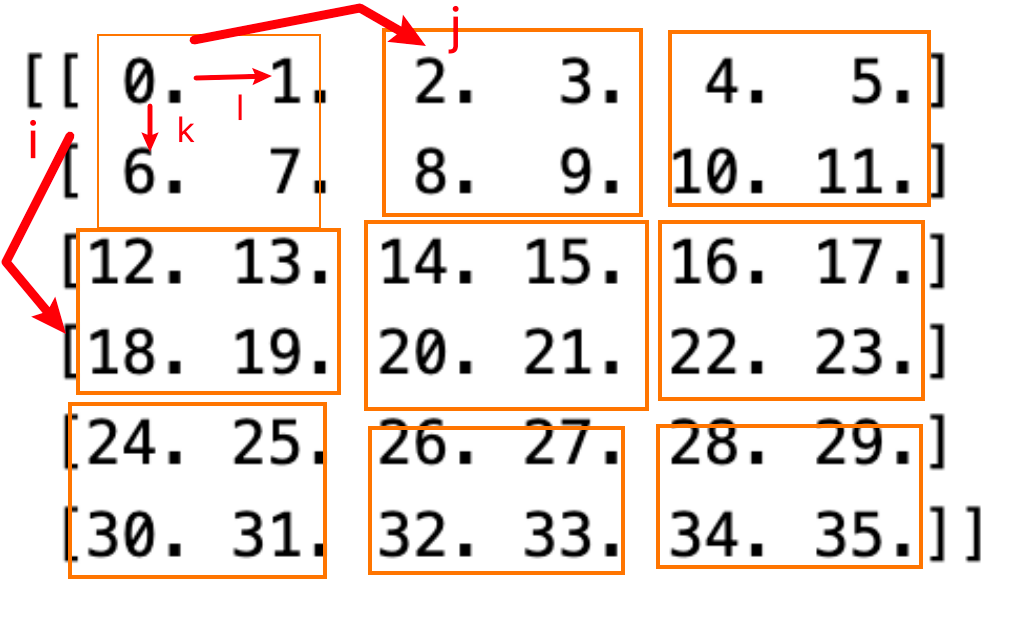

Here's how we can use it to create the tiled view of the matrix `A`.

In [59]:
import numpy as np
n = 6
A = np.arange(n**2, dtype=np.float32).reshape(n,n)
print(A)

[[ 0.  1.  2.  3.  4.  5.]
 [ 6.  7.  8.  9. 10. 11.]
 [12. 13. 14. 15. 16. 17.]
 [18. 19. 20. 21. 22. 23.]
 [24. 25. 26. 27. 28. 29.]
 [30. 31. 32. 33. 34. 35.]]


In [60]:
B = np.lib.stride_tricks.as_strided(A, shape=(3,3,2,2), strides=np.array((12,2,6,1))*4)
print(B)

[[[[ 0.  1.]
   [ 6.  7.]]

  [[ 2.  3.]
   [ 8.  9.]]

  [[ 4.  5.]
   [10. 11.]]]


 [[[12. 13.]
   [18. 19.]]

  [[14. 15.]
   [20. 21.]]

  [[16. 17.]
   [22. 23.]]]


 [[[24. 25.]
   [30. 31.]]

  [[26. 27.]
   [32. 33.]]

  [[28. 29.]
   [34. 35.]]]]


解析NumPy输出的ND数组并不是最直观的事情，但如果你仔细观察，你可以看到这些输出基本上按照期望的方式排列了每个2x2的矩阵块。然而，通过再次检查原始内存，你也可以看到这个调用并没有改变实际的内存布局。

In [61]:
print(np.frombuffer(ctypes.string_at(B.ctypes.data, size=B.nbytes), B.dtype, B.size))

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.]


In [62]:
B.strides  # 12 2 6 1 

(48, 8, 24, 4)

为了重新调整内存布局，使底层矩阵连续/紧凑（这对于使矩阵乘法高效是必需的），我们可以使用`np.ascontiguousarray()`函数。

In [63]:
C = np.ascontiguousarray(B)
print(np.frombuffer(ctypes.string_at(C.ctypes.data, size=C.nbytes), C.dtype, C.size))

[ 0.  1.  6.  7.  2.  3.  8.  9.  4.  5. 10. 11. 12. 13. 18. 19. 14. 15.
 20. 21. 16. 17. 22. 23. 24. 25. 30. 31. 26. 27. 32. 33. 28. 29. 34. 35.]


As you can see, the `C` array is layed out in compact order.  This can also be verified by looking as it's `.strides` property.

In [64]:
C

array([[[[ 0.,  1.],
         [ 6.,  7.]],

        [[ 2.,  3.],
         [ 8.,  9.]],

        [[ 4.,  5.],
         [10., 11.]]],


       [[[12., 13.],
         [18., 19.]],

        [[14., 15.],
         [20., 21.]],

        [[16., 17.],
         [22., 23.]]],


       [[[24., 25.],
         [30., 31.]],

        [[26., 27.],
         [32., 33.]],

        [[28., 29.],
         [34., 35.]]]], dtype=float32)

In [65]:
print(C.strides) # (12, 4, 2, 1)

(48, 16, 8, 4)


## Convolutions via im2col

让我们最后考虑一下实现卷积的“真正”方法，这种方法的速度几乎与PyTorch的实现相当。基本上，我们希望将卷积所需的所有计算捆绑在一个“单独的”矩阵乘法中，然后利用我们为普通矩阵乘法实现的所有优化。

实现这一点的关键方法被称为`im2col`运算符，它将一个4D数组“展开”为执行卷积所需的形式。在进入4D情况之前，让我们看一个如何使用简单的2D数组来实现这个操作的示例，这个数组是我们在上述第一部分中使用的数组。

In [66]:
A = np.arange(36, dtype=np.float32).reshape(6,6)
print(A)

[[ 0.  1.  2.  3.  4.  5.]
 [ 6.  7.  8.  9. 10. 11.]
 [12. 13. 14. 15. 16. 17.]
 [18. 19. 20. 21. 22. 23.]
 [24. 25. 26. 27. 28. 29.]
 [30. 31. 32. 33. 34. 35.]]


And let's consider convolting with a 3x3 filter.

In [67]:
W = np.arange(9, dtype=np.float32).reshape(3,3)
print(W)

[[0. 1. 2.]
 [3. 4. 5.]
 [6. 7. 8.]]


回想一下，卷积将这个滤波器与图像中的每个3x3块进行乘法运算。那么我们如何提取每个这样的3x3块呢？关键在于形成一个$(H-K+1) \times (W-K+1) \times K \times K$的数组，其中包含所有这些块，然后将其展平为一个我们可以用滤波器进行乘法运算的矩阵（这与我们在先前关于1D卷积的讲座中所讨论的数学过程相同，但现在我们要在2D情况下真正执行它）。但是在没有手动复制的情况下，如何创建这个所有块的数组呢？幸运的是，事实证明，我们上面所讨论的`as_strided()`函数实际上正是我们需要的。

具体地说，如果我们创建一个大小为`(4,4,3,3)`的新视图，我们如何使用`as_strided()`返回我们想要的矩阵呢？请注意，前两个维度的步幅与普通的数组一样，为6和1：增加第一个索引1会移动到下一行，增加下一个索引则移动到下一列。但有趣的是（这就是“技巧”），第三和第四个维度的步幅也分别为6和1，因为增加第三个索引1也会移动到下一行，第四个索引同理。让我们看看这在实践中是什么样子。

In [68]:
B = np.lib.stride_tricks.as_strided(A, shape=(4,4,3,3), strides=4*(np.array((6,1,6,1))))
print(B)

[[[[ 0.  1.  2.]
   [ 6.  7.  8.]
   [12. 13. 14.]]

  [[ 1.  2.  3.]
   [ 7.  8.  9.]
   [13. 14. 15.]]

  [[ 2.  3.  4.]
   [ 8.  9. 10.]
   [14. 15. 16.]]

  [[ 3.  4.  5.]
   [ 9. 10. 11.]
   [15. 16. 17.]]]


 [[[ 6.  7.  8.]
   [12. 13. 14.]
   [18. 19. 20.]]

  [[ 7.  8.  9.]
   [13. 14. 15.]
   [19. 20. 21.]]

  [[ 8.  9. 10.]
   [14. 15. 16.]
   [20. 21. 22.]]

  [[ 9. 10. 11.]
   [15. 16. 17.]
   [21. 22. 23.]]]


 [[[12. 13. 14.]
   [18. 19. 20.]
   [24. 25. 26.]]

  [[13. 14. 15.]
   [19. 20. 21.]
   [25. 26. 27.]]

  [[14. 15. 16.]
   [20. 21. 22.]
   [26. 27. 28.]]

  [[15. 16. 17.]
   [21. 22. 23.]
   [27. 28. 29.]]]


 [[[18. 19. 20.]
   [24. 25. 26.]
   [30. 31. 32.]]

  [[19. 20. 21.]
   [25. 26. 27.]
   [31. 32. 33.]]

  [[20. 21. 22.]
   [26. 27. 28.]
   [32. 33. 34.]]

  [[21. 22. 23.]
   [27. 28. 29.]
   [33. 34. 35.]]]]


这正是我们需要的4D数组。现在，如果我们想将卷积计算作为“单一”的矩阵乘法来执行，我们只需将这个数组展平成一个$(4 \cdot 4) \times (3 \cdot 3)$的矩阵，将权重重新调整为一个9维向量（对于多通道卷积情况下，权重将重新调整为一个矩阵），然后执行矩阵乘法。最后，将得到的向量重新调整为一个$4 \times 4$的数组以执行卷积操作。


In [69]:
B.reshape(16, 9)

array([[ 0.,  1.,  2.,  6.,  7.,  8., 12., 13., 14.],
       [ 1.,  2.,  3.,  7.,  8.,  9., 13., 14., 15.],
       [ 2.,  3.,  4.,  8.,  9., 10., 14., 15., 16.],
       [ 3.,  4.,  5.,  9., 10., 11., 15., 16., 17.],
       [ 6.,  7.,  8., 12., 13., 14., 18., 19., 20.],
       [ 7.,  8.,  9., 13., 14., 15., 19., 20., 21.],
       [ 8.,  9., 10., 14., 15., 16., 20., 21., 22.],
       [ 9., 10., 11., 15., 16., 17., 21., 22., 23.],
       [12., 13., 14., 18., 19., 20., 24., 25., 26.],
       [13., 14., 15., 19., 20., 21., 25., 26., 27.],
       [14., 15., 16., 20., 21., 22., 26., 27., 28.],
       [15., 16., 17., 21., 22., 23., 27., 28., 29.],
       [18., 19., 20., 24., 25., 26., 30., 31., 32.],
       [19., 20., 21., 25., 26., 27., 31., 32., 33.],
       [20., 21., 22., 26., 27., 28., 32., 33., 34.],
       [21., 22., 23., 27., 28., 29., 33., 34., 35.]], dtype=float32)

In [70]:
print(np.frombuffer(ctypes.string_at(B.ctypes.data, size=A.nbytes), B.dtype, A.size))

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.]


In [71]:
B.strides

(24, 4, 24, 4)

In [72]:
C = B.reshape(16,9)

In [73]:
C.strides

(36, 4)

In [74]:
(B.reshape(16,9) @ W.reshape(9)).reshape(4,4)

array([[ 366.,  402.,  438.,  474.],
       [ 582.,  618.,  654.,  690.],
       [ 798.,  834.,  870.,  906.],
       [1014., 1050., 1086., 1122.]], dtype=float32)

### A critical note on memory efficiency

关于此操作的内存效率，有一个非常关键的要点需要提醒。虽然将`W`重新调整为一个数组（或对于多通道卷积情况下的矩阵）是“免费”的，即不需要分配额外的内存，但上面提到的将`B`矩阵重新调整为2D矩阵的操作则不是"免费"的。具体来说，当`B`以2D矩阵的形式存在时，不能使用任何形式的步幅来表示这个数据，我们必须分配整个矩阵的内存。这意味着我们实际上需要形成完整的im2col矩阵，这比原始图像需要额外的$O(K^2)$内存，对于较大的核大小可能会非常昂贵。

因此，在实践中，最好的现代实现通常不会实际实例化完整的im2col矩阵，而是执行一种"延迟"形成或将矩阵操作本地专门用于im2col矩阵的本地步幅形式。这些都是相当高级的主题，在课程中我们不会进一步讨论，因为就我们的目的而言，在执行卷积后，只需要分配这个矩阵，然后迅速释放它即可（请记住，我们不需要在im2col操作中进行反向传播等操作）。


### im2col for multi-channel convolutions

要实际实现多通道、小批量卷积的im2col操作，该过程实际上并不复杂。与形成4D的$(H - K + 1) \times (W - K + 1) \times K \times K$数组不同，我们形成一个6D的$N \times (H - K + 1) \times (W - K + 1) \times K \times K \times C$数组（保持小批量和通道维度不变）。想一想，很明显我们可以通过只重复维度1和2（高度和宽度）的步长来为维度3和4（$K \times K$块）应用相同的技巧，并保持小批量和通道的步长不变。此外，你甚至不需要手动计算步长：你可以直接使用输入$Z$的步长，并重复它们的值。

为了计算卷积，您需要将im2col矩阵展平为一个$(N \cdot (H - K + 1) \cdot (W - K + 1)) \times (K \cdot K \cdot C)$的矩阵（请记住，这种操作的内存效率非常低），并将权重数组展平为一个$(K \cdot K \cdot C) \times C_{\text{out}}$的矩阵，执行乘法运算，然后将结果的大小调整回期望的最终4D数组输出大小。下面是完整的操作过程。


In [75]:
def conv_im2col(Z, weight):
    N,H,W,C_in = Z.shape
    K,_,_,C_out = weight.shape
    Ns, Hs, Ws, Cs = Z.strides
    
    inner_dim = K * K * C_in
    A = np.lib.stride_tricks.as_strided(Z, shape = (N, H-K+1, W-K+1, K, K, C_in),
                                        strides = (Ns, Hs, Ws, Hs, Ws, Cs)).reshape(-1,inner_dim)
    out = A @ weight.reshape(-1, C_out)
    return out.reshape(N,H-K+1,W-K+1,C_out)

Again, we can check that this version produces the same output as the PyTorch reference (or our other implementations, at this point):

In [76]:
Z = np.random.randn(100,32,32,8)
W = np.random.randn(3,3,8,16)
out = conv_reference(Z,W)
out2 = conv_im2col(Z,W)
print(np.linalg.norm(out - out2))

0.0


However, at this point we're finally starting to get competetive with PyTorch, taking only 25% more time than the PyTorch implementation on my machine.

In [79]:
%%timeit
out3 = conv_im2col(Z,W)

34.9 ms ± 9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [80]:
%%timeit
out3 = conv_reference(Z,W)

7.05 ms ± 1.06 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Final notes

Hopefully this quick intro gave you a bit of appreciation and understanding of what is going on "under the hood" of modern convolution implementations.  It hopefully also gave you some understanding how just how powerful stride manipulation can be, able to accomplish some very complex operations without actually needing to explicitly loop over matrices (though, as we'll see on the homework, a bit of the complexity is still being outsourced to the `.reshape` and it's implicit `np.ascontinugousarray()` call, which is not completely trivial; but we'll deal with this on the homework.

希望这个简短的介绍让您对现代卷积实现"底层"发生的事情有了一些欣赏和理解。希望这也给您一些对步幅操作有多么强大的认知，能够在没有显式循环矩阵的情况下完成一些非常复杂的操作（尽管在作业中我们将看到一些复杂性仍然被转移到`.reshape`和它的隐式`np.ascontiguousarray()`调用中，这并不完全简单；但这些我们会在作业中处理）。
